## Predicting Airline Satisfaction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes
import pickle

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, classification_report 
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc

from sklearn.neighbors import KNeighborsClassifier
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import plotly.graph_objs as go

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### import data

In [2]:
df = pd.read_csv('../data/train.csv')
df.shape

(98326, 25)

## Exploratory Data Analysis

In [3]:
df.head()

Unnamed: 0      id  Gender      Customer Type  Age   Type of Travel  \
0           0   70172    Male     Loyal Customer   13  Personal Travel   
1           1    5047    Male  disloyal Customer   25  Business travel   
2           2  110028  Female     Loyal Customer   26  Business travel   
3           3   24026  Female     Loyal Customer   25  Business travel   
4           4  119299    Male     Loyal Customer   61  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0  Eco Plus            460.0                    3.0   
1  Business            235.0                    3.0   
2  Business           1142.0                    2.0   
3  Business            562.0                    2.0   
4  Business            214.0                    3.0   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                4.0  ...                     5.0   
1                                2.0  ...                     1.0   
2                                2.0  ...                     5.0   
3                                5.0  ...                     2.0   
4                                3.0  ...                     3.0   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0               4.0               3.0               4.0              4.0   
1               1.0               5.0               3.0              1.0   
2               4.0               3.0               4.0              4.0   
3               2.0               5.0               3.0              1.0   
4               3.0               4.0               4.0              3.0   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0               5.0          5.0                        25.0   
1               4.0          1.0                         1.0   
2               4.0          5.0                         0.0   
3               4.0          2.0                        11.0   
4               3.0          3.0                         0.0   

   Arrival Delay in Minutes             satisfaction  
0                      18.0  neutral or dissatisfied  
1                       6.0  neutral or dissatisfied  
2                       0.0                satisfied  
3                       9.0  neutral or dissatisfied  
4                       0.0                satisfied  

[5 rows x 25 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98326 entries, 0 to 98325
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         98326 non-null  int64  
 1   id                                 98326 non-null  int64  
 2   Gender                             98326 non-null  object 
 3   Customer Type                      98326 non-null  object 
 4   Age                                98326 non-null  int64  
 5   Type of Travel                     98326 non-null  object 
 6   Class                              98325 non-null  object 
 7   Flight Distance                    98325 non-null  float64
 8   Inflight wifi service              98325 non-null  float64
 9   Departure/Arrival time convenient  98325 non-null  float64
 10  Ease of Online booking             98325 non-null  float64
 11  Gate location                      98325 non-null  flo

In [5]:
df = df.drop(df.iloc[:,[0, 1]], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98326 entries, 0 to 98325
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             98326 non-null  object 
 1   Customer Type                      98326 non-null  object 
 2   Age                                98326 non-null  int64  
 3   Type of Travel                     98326 non-null  object 
 4   Class                              98325 non-null  object 
 5   Flight Distance                    98325 non-null  float64
 6   Inflight wifi service              98325 non-null  float64
 7   Departure/Arrival time convenient  98325 non-null  float64
 8   Ease of Online booking             98325 non-null  float64
 9   Gate location                      98325 non-null  float64
 10  Food and drink                     98325 non-null  float64
 11  Online boarding                    98325 non-null  flo

In [6]:
df = df[df['Type of Travel'] != 'Business']

In [7]:
# target variable: satisfaction
print(df[['satisfaction']].value_counts())

satisfaction           
neutral or dissatisfied    55714
satisfied                  42611
dtype: int64


In [8]:
categorical_indexes = [0, 1, 3, 4] + list(range(6, 20))
df.iloc[:,categorical_indexes] = df.iloc[:,categorical_indexes].astype('category')

In [9]:
# continuous variables
df.describe()

Age  Flight Distance  Departure Delay in Minutes  \
count  98325.000000     98325.000000                98325.000000   
mean      39.378571      1189.407353                   14.827907   
std       15.110796       996.605081                   38.252575   
min        7.000000        31.000000                    0.000000   
25%       27.000000       414.000000                    0.000000   
50%       40.000000       843.000000                    0.000000   
75%       51.000000      1742.000000                   12.000000   
max       85.000000      4983.000000                 1592.000000   

       Arrival Delay in Minutes  
count              98029.000000  
mean                  15.190790  
std                   38.726291  
min                    0.000000  
25%                    0.000000  
50%                    0.000000  
75%                   13.000000  
max                 1584.000000

In [10]:
# include categorical variables
df.describe(include = ['category'])

Gender   Customer Type   Type of Travel     Class  \
count    98325           98325            98325     98325   
unique       2               2                2         3   
top     Female  Loyal Customer  Business travel  Business   
freq     49908           80318            67826     46995   

        Inflight wifi service  Departure/Arrival time convenient  \
count                 98325.0                            98325.0   
unique                    6.0                                6.0   
top                       2.0                                4.0   
freq                  24481.0                            24196.0   

        Ease of Online booking  Gate location  Food and drink  \
count                  98325.0        98325.0         98325.0   
unique                     6.0            6.0             6.0   
top                        3.0            3.0             4.0   
freq                   23146.0        27053.0         23086.0   

        Online boarding  Seat comfort  Inflight entertainment  \
count           98325.0       98325.0                 98325.0   
unique              6.0           6.0                     6.0   
top                 4.0           4.0                     4.0   
freq            29144.0       30093.0                 27839.0   

        On-board service  Leg room service  Baggage handling  Checkin service  \
count            98325.0           98325.0           98325.0          98325.0   
unique               6.0               6.0               5.0              6.0   
top                  4.0               4.0               4.0              4.0   
freq             29178.0           27235.0           35334.0          27527.0   

        Inflight service  Cleanliness  
count            98325.0      98325.0  
unique               6.0          6.0  
top                  4.0          4.0  
freq             35887.0      25749.0

#### Feature Ralationships

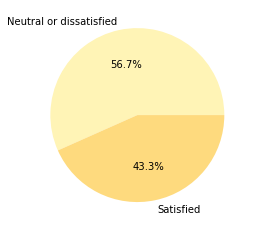

In [11]:
plt.pie(df.satisfaction.value_counts(), labels = ["Neutral or dissatisfied", "Satisfied"], colors = sns.color_palette("YlOrBr"), autopct = '%1.1f%%')
pass

In [12]:
corr_mat = df.corr()
corr_mat

Age  Flight Distance  \
Age                         1.000000         0.098708   
Flight Distance             0.098708         1.000000   
Departure Delay in Minutes -0.010127         0.002349   
Arrival Delay in Minutes   -0.012232        -0.002115   

                            Departure Delay in Minutes  \
Age                                          -0.010127   
Flight Distance                               0.002349   
Departure Delay in Minutes                    1.000000   
Arrival Delay in Minutes                      0.965670   

                            Arrival Delay in Minutes  
Age                                        -0.012232  
Flight Distance                            -0.002115  
Departure Delay in Minutes                  0.965670  
Arrival Delay in Minutes                    1.000000

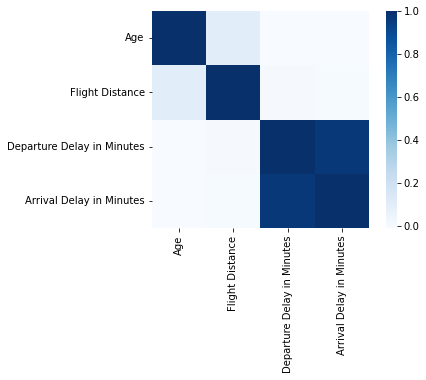

In [13]:
sns.heatmap(corr_mat, square = True, cmap = 'Blues')
pass

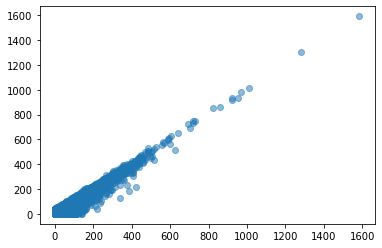

In [14]:
plt.scatter(df['Arrival Delay in Minutes'], df['Departure Delay in Minutes'], alpha = 0.5)
pass

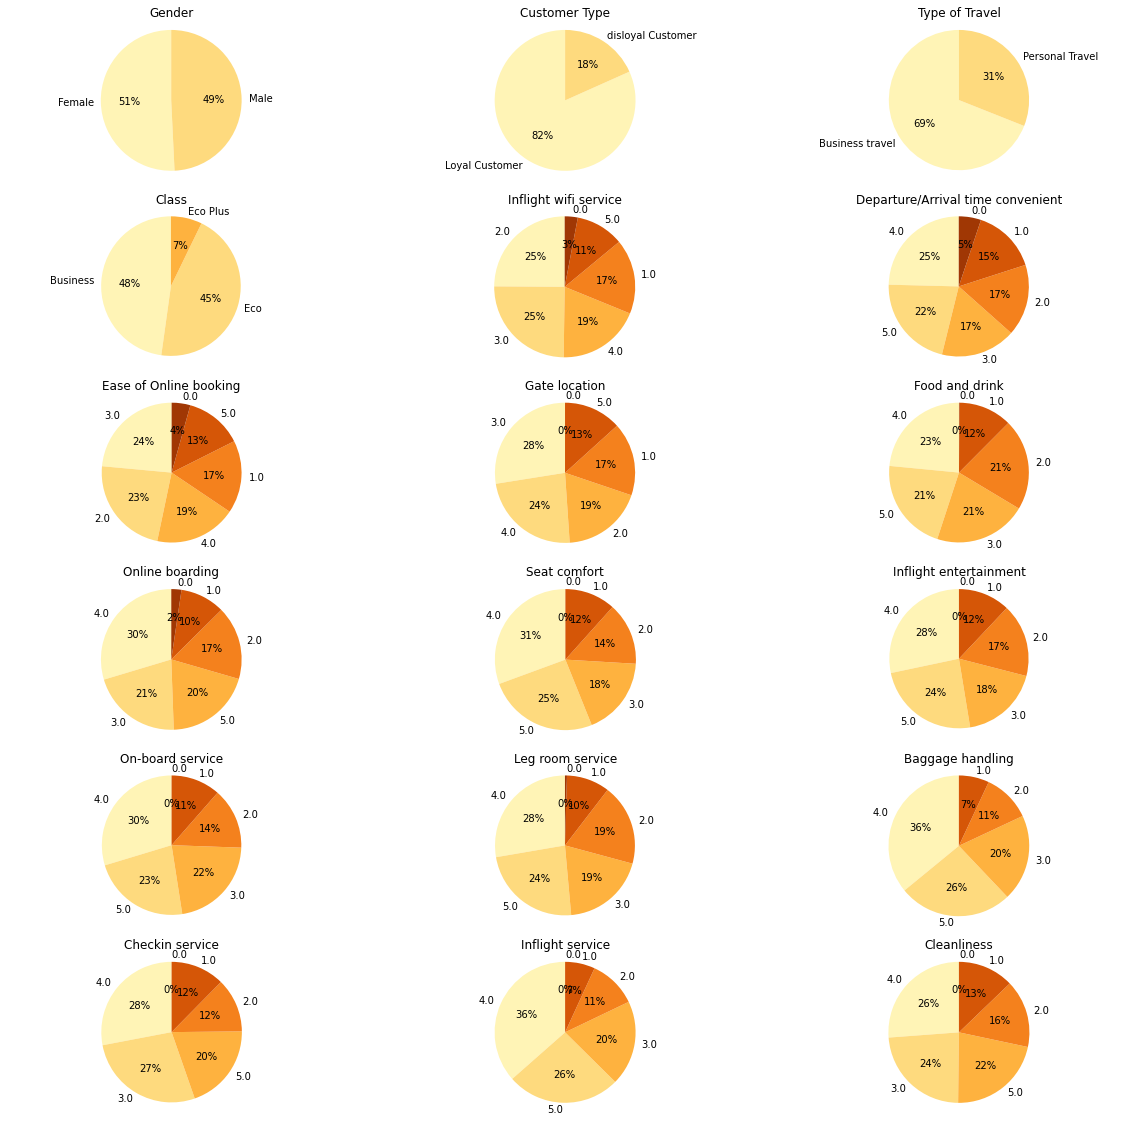

In [15]:
categ = df.iloc[:,categorical_indexes]
fig, axes = plt.subplots(6, 3, figsize = (20, 20))
for i, col in enumerate(categ):
    column_values = df[col].value_counts()
    labels = column_values.index
    sizes = column_values.values
    axes[i//3, i%3].pie(sizes, labels = labels, colors = sns.color_palette("YlOrBr"), autopct = '%1.0f%%', startangle = 90)
    axes[i//3, i%3].axis('equal')
    axes[i//3, i%3].set_title(col)
plt.show()

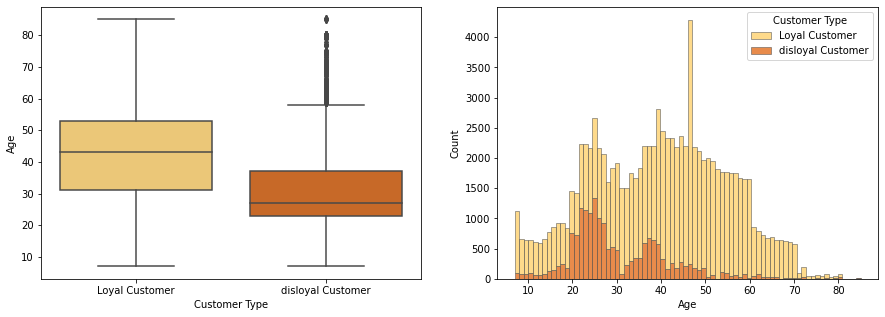

In [16]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Customer Type", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Age", hue = "Customer Type", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

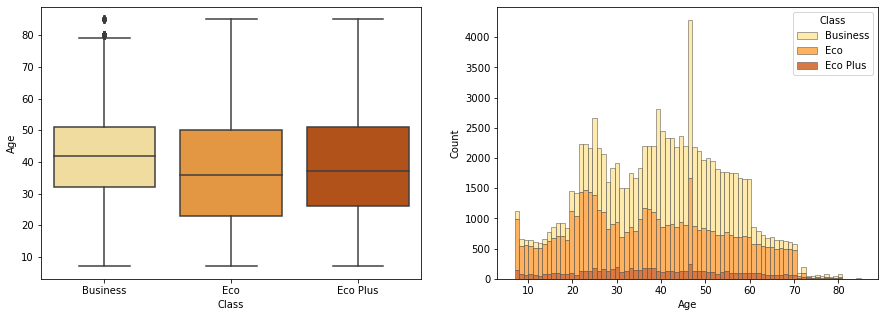

In [17]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Age", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Age", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

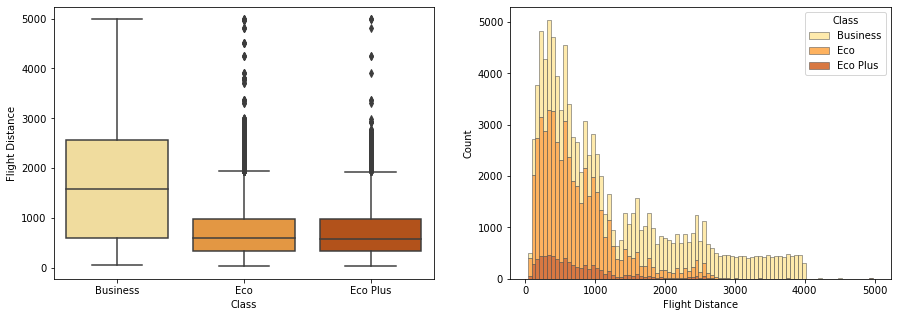

In [18]:
f, ax = plt.subplots(1, 2, figsize = (15,5))
sns.boxplot(x = "Class", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0])
sns.histplot(df, x = "Flight Distance", hue = "Class", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1])
pass

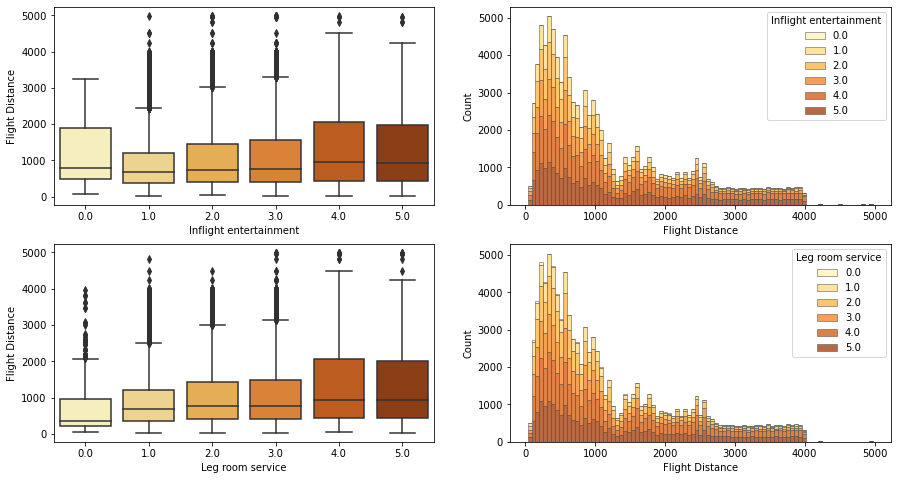

In [19]:
f, ax = plt.subplots(2, 2, figsize = (15,8))
sns.boxplot(x = "Inflight entertainment", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[0, 0])
sns.histplot(df, x = "Flight Distance", hue = "Inflight entertainment", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[0, 1])
sns.boxplot(x = "Leg room service", y = "Flight Distance", palette = "YlOrBr", data = df, ax = ax[1, 0])
sns.histplot(df, x = "Flight Distance", hue = "Leg room service", multiple = "stack", palette = "YlOrBr", edgecolor = ".3", linewidth = .5, ax = ax[1, 1])
pass

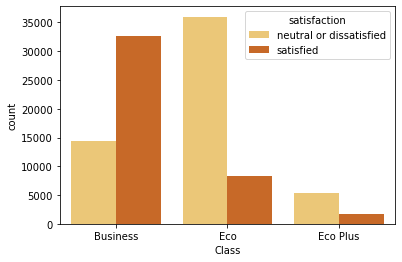

In [20]:
sns.countplot(x = 'Class', hue = 'satisfaction', palette = "YlOrBr", data = df)
plt.show()

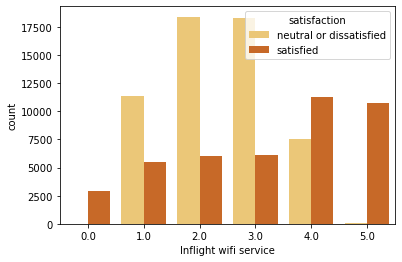

In [21]:
sns.countplot(x = 'Inflight wifi service', hue = 'satisfaction', palette = "YlOrBr", data = df)
plt.show()

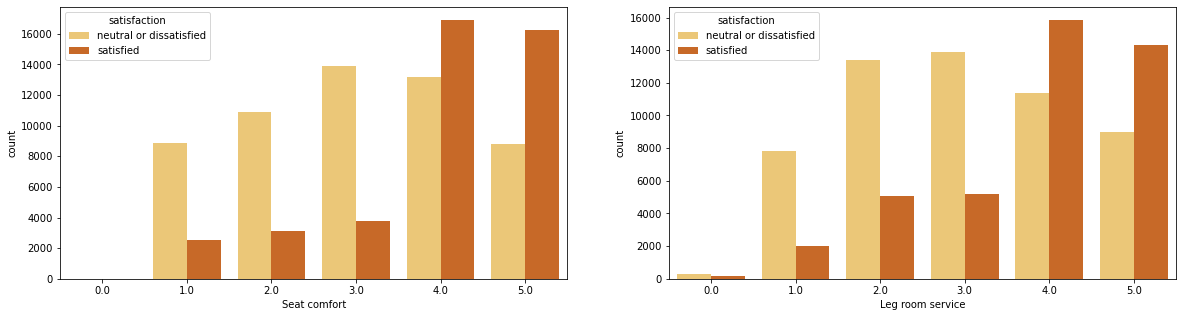

In [22]:
f, ax = plt.subplots(1, 2, figsize = (20,5))
sns.countplot(x = 'Seat comfort', hue = 'satisfaction', palette = "YlOrBr", data = df,ax = ax[0])
sns.countplot(x = 'Leg room service', hue = 'satisfaction', palette = "YlOrBr", data = df, ax = ax[1])
plt.show()

### Data Cleaning
- drop all NAs
- in a future iteration, we might improve performance by imputing rather than dropping

In [23]:
df.isna().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             296
satisfaction                           0
dtype: int64

In [24]:
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(axis = 0), inplace = True)

In [25]:
df.isna().sum()

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

## Categorical variables
- each column translated to binary value
- multi variables columns slpitted with dummy columns
- drop the duplications in the data

In [26]:
numerical_columns = [c for c in df.columns if df[c].dtype.name != 'category']
numerical_columns.remove('satisfaction')
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'category']
data_describe = df.describe(include = ['category'])

In [27]:
binary_columns = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Gender', 'Customer Type', 'Type of Travel'] ['Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']


In [28]:
for col in binary_columns:
    print(col, ': ', end = '')
    for uniq in df[col].unique():
        if uniq == df[col].unique()[-1]:
            print(uniq, end = '.')
        else:
            print(uniq, end = ', ')
    print()

Gender : Male, Female.
Customer Type : Loyal Customer, disloyal Customer.
Type of Travel : Personal Travel, Business travel.


In [29]:
for col in binary_columns:
    df[col] = df[col].astype('object')
    k = 0
    for uniq in df[col].unique():
        df.at[df[col] == uniq, col] = k
        k +=1 
for col in binary_columns:
    print(df[col].describe(), end = '\n\n')

count     98325
unique        2
top           1
freq      49908
Name: Gender, dtype: int64

count     98325
unique        2
top           0
freq      80318
Name: Customer Type, dtype: int64

count     98325
unique        2
top           1
freq      67826
Name: Type of Travel, dtype: int64



In [30]:
data_nonbinary = pd.get_dummies(df[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Class_Business', 'Class_Eco', 'Class_Eco Plus',
       'Inflight wifi service_0.0', 'Inflight wifi service_1.0',
       'Inflight wifi service_2.0', 'Inflight wifi service_3.0',
       'Inflight wifi service_4.0', 'Inflight wifi service_5.0',
       'Departure/Arrival time convenient_0.0',
       'Departure/Arrival time convenient_1.0',
       'Departure/Arrival time convenient_2.0',
       'Departure/Arrival time convenient_3.0',
       'Departure/Arrival time convenient_4.0',
       'Departure/Arrival time convenient_5.0', 'Ease of Online booking_0.0',
       'Ease of Online booking_1.0', 'Ease of Online booking_2.0',
       'Ease of Online booking_3.0', 'Ease of Online booking_4.0',
       'Ease of Online booking_5.0', 'Gate location_0.0', 'Gate location_1.0',
       'Gate location_2.0', 'Gate location_3.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_0.0', 'Food and drink_1.0',
       'Food and drink_2.0', 'Food and drink_3.0', 'Food and drink_4.0',
   

#### Normalize

In [31]:
data_numerical = df[numerical_columns]
data_numerical.describe()

Age  Flight Distance  Departure Delay in Minutes  \
count  98325.000000     98325.000000                98325.000000   
mean      39.378571      1189.407353                   14.827907   
std       15.110796       996.605081                   38.252575   
min        7.000000        31.000000                    0.000000   
25%       27.000000       414.000000                    0.000000   
50%       40.000000       843.000000                    0.000000   
75%       51.000000      1742.000000                   12.000000   
max       85.000000      4983.000000                 1592.000000   

       Arrival Delay in Minutes  
count               98325.00000  
mean                   15.14506  
std                    38.67691  
min                     0.00000  
25%                     0.00000  
50%                     0.00000  
75%                    13.00000  
max                  1584.00000

In [32]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)

In [33]:
data_numerical.describe()

Age  Flight Distance  Departure Delay in Minutes  \
count  9.832500e+04     9.832500e+04                9.832500e+04   
mean  -2.104664e-16     1.144492e-16                1.871656e-17   
std    1.000000e+00     1.000000e+00                1.000000e+00   
min   -2.142744e+00    -1.162353e+00               -3.876316e-01   
25%   -8.191872e-01    -7.780488e-01               -3.876316e-01   
50%    4.112483e-02    -3.475874e-01               -3.876316e-01   
75%    7.690812e-01     5.544750e-01               -7.392724e-02   
max    3.019128e+00     3.806515e+00                4.123048e+01   

       Arrival Delay in Minutes  
count              9.832500e+04  
mean              -5.736011e-18  
std                1.000000e+00  
min               -3.915788e-01  
25%               -3.915788e-01  
50%               -3.915788e-01  
75%               -5.546099e-02  
max                4.056309e+01

In [34]:
df['satisfaction']

0        neutral or dissatisfied
1        neutral or dissatisfied
2                      satisfied
3        neutral or dissatisfied
4                      satisfied
                  ...           
98320                  satisfied
98321                  satisfied
98322    neutral or dissatisfied
98323                  satisfied
98324    neutral or dissatisfied
Name: satisfaction, Length: 98325, dtype: object

In [35]:
df['satisfaction'].replace({'satisfied': 1,'neutral or dissatisfied':0},inplace=True)
target = df['satisfaction']
target

0        0
1        0
2        1
3        0
4        1
        ..
98320    1
98321    1
98322    0
98323    1
98324    0
Name: satisfaction, Length: 98325, dtype: int64

In [36]:
df = pd.concat((data_numerical, data_nonbinary, df[binary_columns]), axis = 1)
print(df.shape)

(98325, 93)


In [37]:
df.describe()

Age  Flight Distance  Departure Delay in Minutes  \
count  9.832500e+04     9.832500e+04                9.832500e+04   
mean  -2.104664e-16     1.144492e-16                1.871656e-17   
std    1.000000e+00     1.000000e+00                1.000000e+00   
min   -2.142744e+00    -1.162353e+00               -3.876316e-01   
25%   -8.191872e-01    -7.780488e-01               -3.876316e-01   
50%    4.112483e-02    -3.475874e-01               -3.876316e-01   
75%    7.690812e-01     5.544750e-01               -7.392724e-02   
max    3.019128e+00     3.806515e+00                4.123048e+01   

       Arrival Delay in Minutes  Class_Business     Class_Eco  Class_Eco Plus  \
count              9.832500e+04    98325.000000  98325.000000    98325.000000   
mean              -5.736011e-18        0.477956      0.449987        0.072057   
std                1.000000e+00        0.499516      0.497495        0.258584   
min               -3.915788e-01        0.000000      0.000000        0.000000   
25%               -3.915788e-01        0.000000      0.000000        0.000000   
50%               -3.915788e-01        0.000000      0.000000        0.000000   
75%               -5.546099e-02        1.000000      1.000000        0.000000   
max                4.056309e+01        1.000000      1.000000        1.000000   

       Inflight wifi service_0.0  Inflight wifi service_1.0  \
count               98325.000000               98325.000000   
mean                    0.029860                   0.171625   
std                     0.170202                   0.377056   
min                     0.000000                   0.000000   
25%                     0.000000                   0.000000   
50%                     0.000000                   0.000000   
75%                     0.000000                   0.000000   
max                     1.000000                   1.000000   

       Inflight wifi service_2.0  ...  Inflight service_2.0  \
count               98325.000000  ...          98325.000000   
mean                    0.248980  ...              0.110369   
std                     0.432425  ...              0.313350   
min                     0.000000  ...              0.000000   
25%                     0.000000  ...              0.000000   
50%                     0.000000  ...              0.000000   
75%                     0.000000  ...              0.000000   
max                     1.000000  ...              1.000000   

       Inflight service_3.0  Inflight service_4.0  Inflight service_5.0  \
count          98325.000000          98325.000000          98325.000000   
mean               0.195250              0.364983              0.260880   
std                0.396395              0.481428              0.439117   
min                0.000000              0.000000              0.000000   
25%                0.000000              0.000000              0.000000   
50%                0.000000              0.000000              0.000000   
75%                0.000000              1.000000              1.000000   
max                1.000000              1.000000              1.000000   

       Cleanliness_0.0  Cleanliness_1.0  Cleanliness_2.0  Cleanliness_3.0  \
count     98325.000000     98325.000000     98325.000000     98325.000000   
mean          0.000122         0.127984         0.155230         0.236359   
std           0.011047         0.334073         0.362126         0.424847   
min           0.000000         0.000000         0.000000         0.000000   
25%           0.000000         0.000000         0.000000         0.000000   
50%           0.000000         0.000000         0.000000         0.000000   
75%           0.000000         0.000000         0.000000         0.000000   
max           1.000000         1.000000         1.000000         1.000000   

       Cleanliness_4.0  Cleanliness_5.0  
count     98325.000000     98325.000000  
mean          0.261876         0.218429  
std           0.439658         0.413182  

## Model evaluation 

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(df)

In [38]:
X = df
y = target
N, d = X.shape
N, d

(98325, 93)

In [39]:
X.columns

Index(['Age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Class_Business', 'Class_Eco',
       'Class_Eco Plus', 'Inflight wifi service_0.0',
       'Inflight wifi service_1.0', 'Inflight wifi service_2.0',
       'Inflight wifi service_3.0', 'Inflight wifi service_4.0',
       'Inflight wifi service_5.0', 'Departure/Arrival time convenient_0.0',
       'Departure/Arrival time convenient_1.0',
       'Departure/Arrival time convenient_2.0',
       'Departure/Arrival time convenient_3.0',
       'Departure/Arrival time convenient_4.0',
       'Departure/Arrival time convenient_5.0', 'Ease of Online booking_0.0',
       'Ease of Online booking_1.0', 'Ease of Online booking_2.0',
       'Ease of Online booking_3.0', 'Ease of Online booking_4.0',
       'Ease of Online booking_5.0', 'Gate location_0.0', 'Gate location_1.0',
       'Gate location_2.0', 'Gate location_3.0', 'Gate location_4.0',
       'Gate location_5.0', 'Food and drink_0.0', 'Food a

In [40]:
y

0        0
1        0
2        1
3        0
4        1
        ..
98320    1
98321    1
98322    0
98323    1
98324    0
Name: satisfaction, Length: 98325, dtype: int64

In [41]:
def mod_eval(df,predictions, y_test, title):
    # prints confusion matrix heatmap    
    cm = confusion_matrix(y[y_test.index], predictions)
    sns.heatmap(cm, annot=True, fmt='.3g', xticklabels=['neutral or dissatisfied', 'satisfied'], yticklabels=['satisfied', 'neutral or dissatisfied']).set_title(title)
    plt.xlabel('Real')
    plt.ylabel('Predict')
    
    print(classification_report(y[y_test.index], predictions))

In [42]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 777)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(9832, 88493)

## K-nearest neighbors (kNN) method

In [43]:
knn = KNeighborsClassifier()

knn.set_params(n_neighbors = 9)
knn.fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print('Training sample error: ', err_train)
print('Error on the test sample: ', err_test)

Training sample error:  0.06722945484133441
Error on the test sample:  0.08600680279796143


              precision    recall  f1-score   support

           0       0.92      0.93      0.92     50036
           1       0.91      0.89      0.90     38457

    accuracy                           0.91     88493
   macro avg       0.91      0.91      0.91     88493
weighted avg       0.91      0.91      0.91     88493



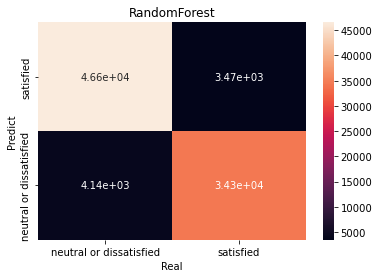

In [44]:
# evaluate the model
predprob = knn.predict_proba(X_test)
mod_eval(y, knn.predict(X_test),  y_test, 'RandomForest')

## Random Forest

In [45]:
# grid search for optimal hyperparameters
grid_values = {'max_features': [4, 5, 6, 7],
              'max_depth': [3, 7, 11, 13],
               'n_estimators':[50,100,150]
              }

In [46]:
# grid search for optimal hyperparameters
model = RandomForestClassifier(random_state=42, 
                               n_jobs=4)
rf = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
rf.fit(X_train,y_train)
print(rf.best_params_)
print(rf.best_score_)

{'max_depth': 13, 'max_features': 7, 'n_estimators': 150}
0.9431466087700361


              precision    recall  f1-score   support

           0       0.93      0.96      0.95     50036
           1       0.95      0.91      0.93     38457

    accuracy                           0.94     88493
   macro avg       0.94      0.94      0.94     88493
weighted avg       0.94      0.94      0.94     88493



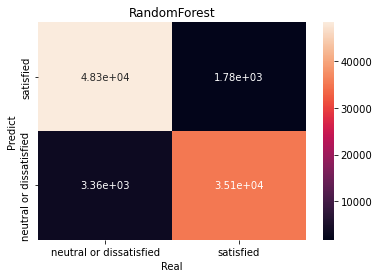

In [47]:
# evaluate the model
predprob = rf.predict_proba(X_test)
mod_eval(y, rf.predict(X_test),  y_test, 'RandomForest')

## LogisticRegression

In [48]:
# grid search for optimal hyperparameters
grid_values = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
               'solver':['liblinear'] # this is the only solver that allow parameters
              }

In [49]:
# grid search for optimal hyperparameters
model = LogisticRegression(max_iter=1000)
lr = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
lr.fit(X_train,y_train)
print(lr.best_params_)
print(lr.best_score_)

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.9341956111030374


              precision    recall  f1-score   support

           0       0.93      0.95      0.94     50036
           1       0.93      0.91      0.92     38457

    accuracy                           0.93     88493
   macro avg       0.93      0.93      0.93     88493
weighted avg       0.93      0.93      0.93     88493



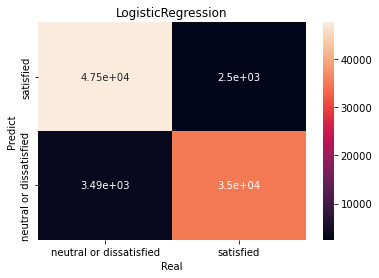

In [50]:
# evaluate the model
predprob = lr.predict_proba(X_test)
mod_eval(y, lr.predict(X_test), y_test, 'LogisticRegression') 

## NaiveBayes

              precision    recall  f1-score   support

           0       0.94      0.76      0.84     50036
           1       0.75      0.94      0.83     38457

    accuracy                           0.83     88493
   macro avg       0.84      0.85      0.83     88493
weighted avg       0.85      0.83      0.83     88493



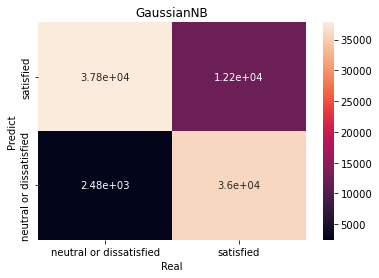

In [51]:
# there are no hyperparameters to gridsearch
gnb = GaussianNB()
gnb.fit(X_train, y_train)
mod_eval(y, gnb.predict(X_test),  y_test, 'GaussianNB')

## SVC

#### Make the training set smaller due to my laptop limitation

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.9, random_state = 777)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

In [52]:
# grid search for optimal hyperparameters
grid_values = {'C': [1, 10],
              'gamma': [0.5, 0.7, 0.9, 0.95],
              'kernel':['linear','poly','rbf']
              }

In [53]:
# grid search for optimal hyperparameters
model = SVC(class_weight='balanced',probability=True)
svc = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
svc.fit(X_train,y_train)
print(svc.best_params_)
print(svc.best_score_)

{'C': 1, 'gamma': 0.5, 'kernel': 'poly'}
0.9389763239949502


              precision    recall  f1-score   support

           0       0.94      0.95      0.95     50036
           1       0.94      0.92      0.93     38457

    accuracy                           0.94     88493
   macro avg       0.94      0.94      0.94     88493
weighted avg       0.94      0.94      0.94     88493



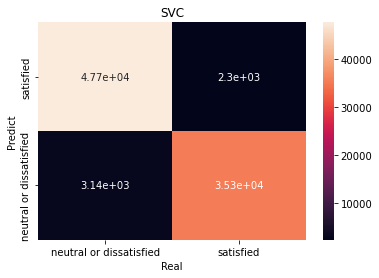

In [54]:
# evaluate
predprob = svc.predict_proba(X_test)
mod_eval(y,svc.predict(X_test), y_test, 'SVC')
plt.show()

## Adaboost

In [55]:
# grid search for optimal hyperparameters
grid_values = {'learning_rate': [1, 2, 3],
               'n_estimators':[50,100,150]}

In [56]:
# grid search for optimal hyperparameters
model = AdaBoostClassifier()
boost = GridSearchCV(model, param_grid=grid_values, scoring='accuracy', cv=5)
boost.fit(X_train,y_train)
print(boost.best_params_)
print(boost.best_score_)

{'learning_rate': 1, 'n_estimators': 150}
0.9269738063603891


              precision    recall  f1-score   support

           0       0.93      0.94      0.93     50036
           1       0.92      0.91      0.91     38457

    accuracy                           0.92     88493
   macro avg       0.92      0.92      0.92     88493
weighted avg       0.92      0.92      0.92     88493



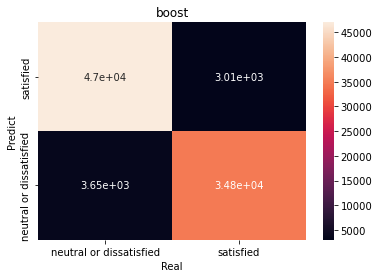

In [57]:
# evaluate the model
predprob = boost.predict_proba(X_test)
mod_eval(y,boost.predict(X_test),  y_test, 'boost')
plt.show()

## Compare Models

In [58]:
# compare final models: accuracy
import sklearn
accuracy_vals=[]
for val in [rf.predict(X_test),
lr.predict(X_test),
gnb.predict(X_test),
svc.predict(X_test),
boost.predict(X_test),      
           ]:
    accuracy_vals.append(sklearn.metrics.accuracy_score(val, y_test.values))
accuracy_vals

[0.9419615110799724,
 0.9322093272914241,
 0.8337269614545784,
 0.93861661374346,
 0.924762410586148]

In [59]:
# compare final models: ROCAUC
roc_vals=[]
for val in [rf.predict(X_test),
            lr.predict(X_test),
            gnb.predict(X_test),
            svc.predict(X_test),
           boost.predict(X_test)]:
    roc_vals.append(sklearn.metrics.roc_auc_score(val, y_test.values))
roc_vals

[0.9433718128991988,
 0.9323333557554284,
 0.8423545987278483,
 0.9386587980786408,
 0.9242184160177099]

In [60]:
# display final values
models = ['random forest', 'logistic regression', 'naive bayes', 'support vector', 'boosted']
evaldf = pd.DataFrame(list(zip(models, accuracy_vals, roc_vals)))
evaldf.columns=['model', 'accuracy', 'rocauc']
evaldf=evaldf.set_index('model', drop=True)
evaldf

accuracy    rocauc
model                                  
random forest        0.941962  0.943372
logistic regression  0.932209  0.932333
naive bayes          0.833727  0.842355
support vector       0.938617  0.938659
boosted              0.924762  0.924218

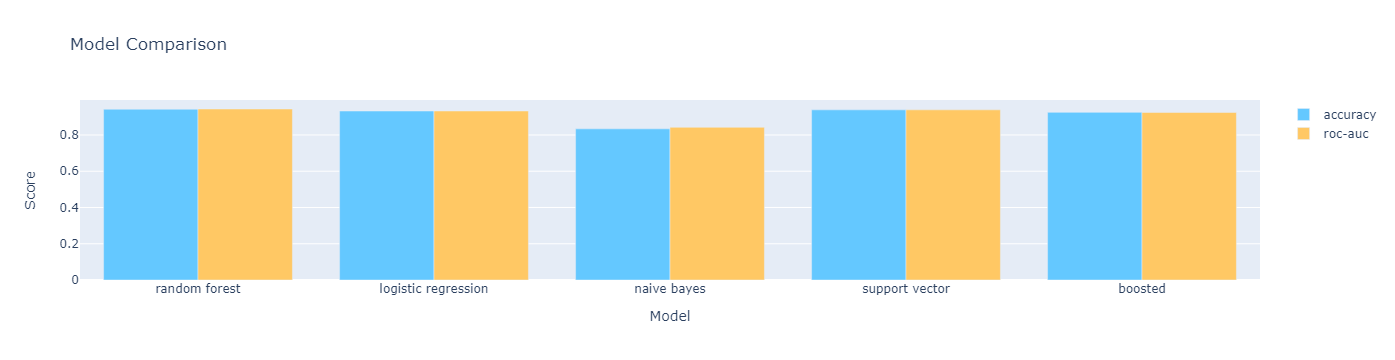

In [61]:
# display results with plotly
trace0 = go.Bar(x= evaldf.index,
                y= evaldf['accuracy'].values,
                name='accuracy',
                marker=dict(color='rgb(100,200,300)'))
trace1 = go.Bar(x= evaldf.index,
                y= evaldf['rocauc'].values,
                name='roc-auc',
                marker=dict(color='rgb(300,200,100)'))
# now the layout
layout=go.Layout(title='Model Comparison',
                   xaxis= dict(title='Model'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0, trace1], layout=layout)
fig

### Side note: Visualize the ROC-AUC curve

In [62]:
# true positives, etc.
y_score = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresh=roc_curve(y_test, y_score)
roc_df=pd.DataFrame(zip(fpr, tpr, thresh), columns=['FPR','TPR','Threshold'])
roc_df.head()


FPR       TPR  Threshold
0  0.0  0.000000   1.999269
1  0.0  0.000026   0.999269
2  0.0  0.000104   0.999213
3  0.0  0.000260   0.999057
4  0.0  0.000312   0.998993

In [63]:
import plotly.express as px

def make_rocauc(i):
    nearest=roc_df.iloc[(roc_df['Threshold']-i).abs().argsort()[:1]]['Threshold'].values[0]
    q=roc_df[roc_df['Threshold']==nearest].index[0]
    print(nearest, q)
    fig = px.area(roc_df, x="FPR", y="TPR",
                  title=f'ROC Curve (AUC={auc(fpr, tpr):.3f})',
                  hover_data={'Threshold':':.2f',
                              'FPR':':.2f',
                              'TPR':':.2f',
                             },width=800, height=700)

    fig.add_annotation(x=roc_df.iloc[q][0], y=roc_df.iloc[q][1],
            text=f"Threshold nearest {i*100:.0f}% = {roc_df.iloc[q][2]:.2f}",
                showarrow=True,
                arrowhead=1)

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    return fig

0.6000245033797973 2782


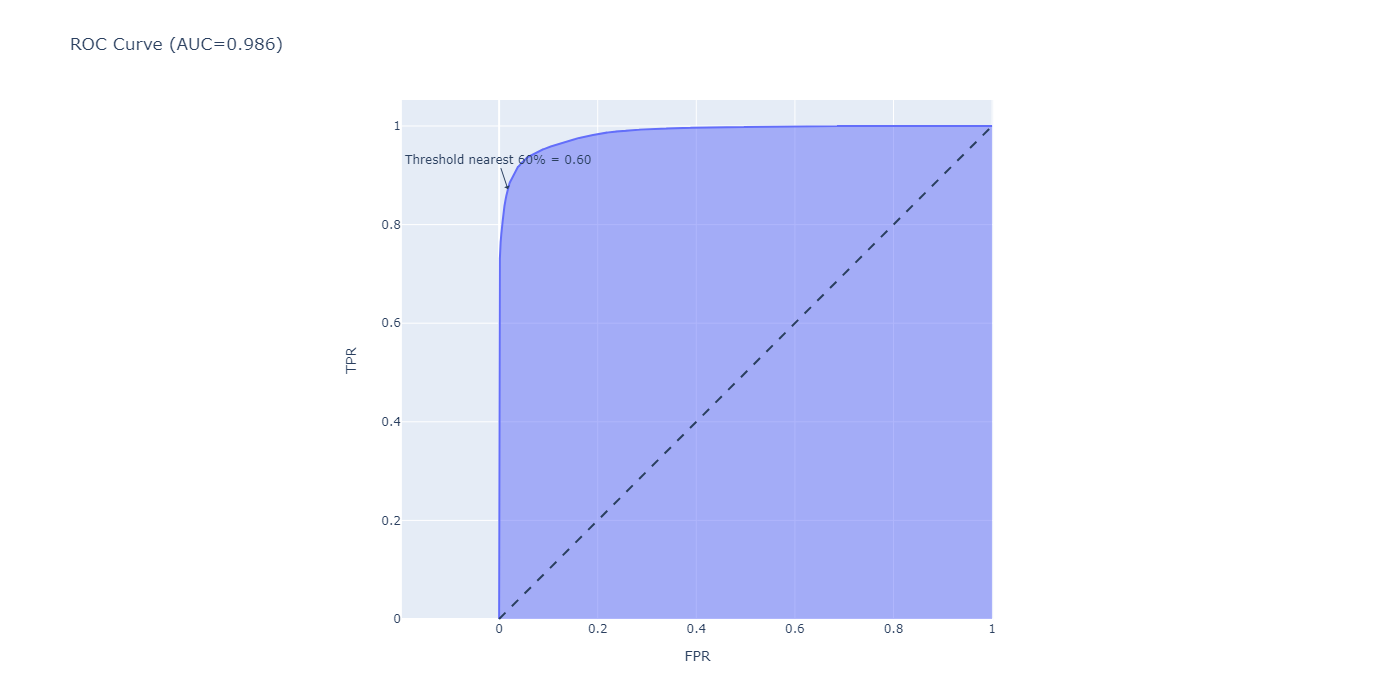

In [64]:
# choose a threshold for prediction.
make_rocauc(.60)

## Take a look at the final results

In [65]:
# Random Forest feature importance
fi_df = pd.DataFrame({'fi': rf.best_estimator_.feature_importances_},index=X_train.columns).sort_values(by='fi', ascending=False)
fi_df

fi
Class_Business             0.087134
Type of Travel             0.074269
Online boarding_5.0        0.062881
Class_Eco                  0.062488
Inflight wifi service_5.0  0.061834
...                             ...
Inflight service_0.0       0.000000
Checkin service_0.0        0.000000
Seat comfort_0.0           0.000000
On-board service_0.0       0.000000
Gate location_0.0          0.000000

[93 rows x 1 columns]

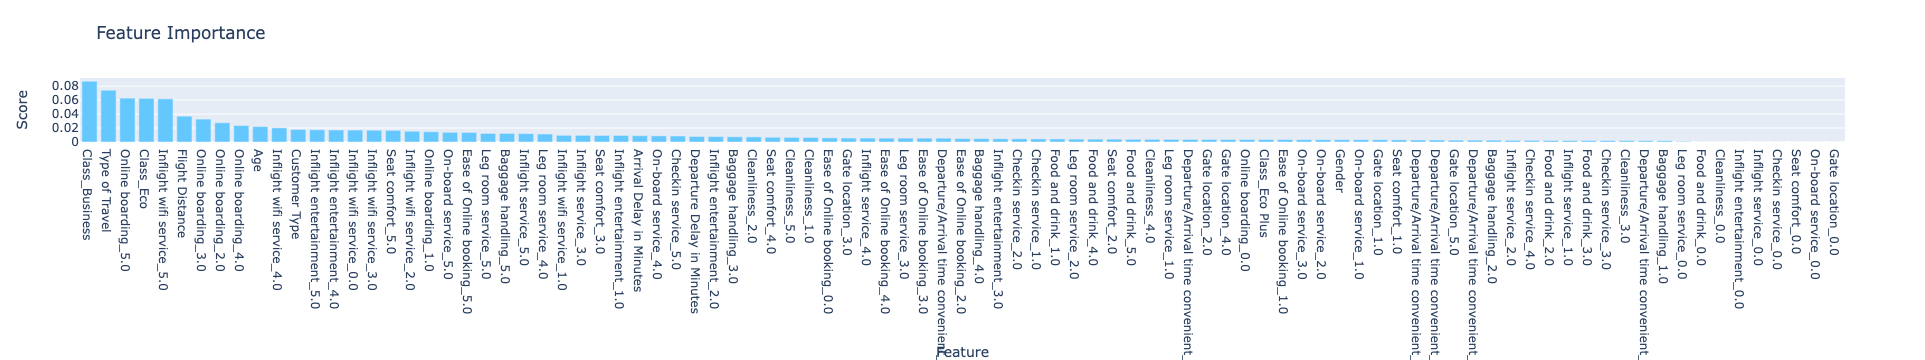

In [66]:
# display results with plotly
trace0 = go.Bar(x= fi_df.index,
                y= fi_df['fi'].values,
                marker=dict(color='rgb(100,200,300)'))

# now the layout
layout=go.Layout(title='Feature Importance',
                   xaxis= dict(title='Feature'),
                   yaxis=dict(title='Score'))
# bind using go.Figure
fig = go.Figure(data=[trace0], layout=layout)
fig

In [70]:
# what are the key variables like?
X_test[['Class_Business', 'Type of Travel', 'Online boarding_5.0', 'Class_Eco']].sample(3).T

92750 37331 57221
Class_Business          0     1     0
Type of Travel          0     1     0
Online boarding_5.0     0     1     0
Class_Eco               1     0     0